In [1]:
# If i want to update stardist
import sys
from pystackreg import StackReg
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from skimage import filters
import numpy as np
from tifffile import imsave as tif_imsave
from tifffile import imread as tif_imread
from csbdeep.utils import normalize

import matplotlib.pyplot as plt
import sys
from tqdm.auto import tqdm,trange
sys.path.append('/home/oamsalem/code/Projects/EZfish')
#import gui
from sbxreader import sbx_memmap
import os
from skimage.morphology import disk

from cellpose import models,dynamics
from tifffile import imread as tif_imread
# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'

from cellpose import models
from pathlib import Path

import time
import scipy.ndimage as ndm

In [2]:
def pred_func_auto(data, merge_type, anisotropy, stitch_thres, flow_threshold= 0.4):
    # Flow Threshold does not matter!
    if merge_type == 'flow':
        masks, flows, styles, _ = model.eval(data, channels=[0,0], diameter=diameter, do_3D=True, anisotropy=anisotropy,flow_threshold=flow_threshold)
    elif merge_type == 'stitch':
        masks, flows_stitched, styles_stitched, _ = model.eval(data, channels=[0,0], diameter=diameter, do_3D=False, stitch_threshold=stitch_thres,anisotropy=anisotropy)
    return masks


def pred_func_custom(data, merge_type, anisotropy, stitch_thres, flow_threshold= 0.4):
    if merge_type == 'flow':
        masks, flows, styles = model.eval(data, channels=[0,0], diameter=diameter, do_3D=True, anisotropy=anisotropy,flow_threshold=flow_threshold) #play with additional parameters
    elif merge_type == 'stitch':
        masks, flows_stitched, styles_stitched = model.eval(data, channels=[0,0], diameter=diameter, do_3D=False, stitch_threshold=stitch_thres,anisotropy=anisotropy)
    return masks, flows, styles



In [3]:
#time.sleep(2*60*60) #delay in case upstream code is running

bounds = (160,670,21,471)#x_st,x_en,y_st,y_en

funs = ['mean']#median']
regs = ['']#AFFINE']
filters_pipe = ['']# {'gaus':10,'med':15}]
debug_f = ''#sig'
anisotropy = 4 # None | 20 
stitch_thres = 0.4 # 0.4 | 0
merge_type = 'flow' # flow|stitch, stitch doesn't do 3D but just stitches based on some size parameters e.g. diameter
#flow_threshold = 0.2
diameter = 20 #default is 30
blur = True #to smoothen out flow model output - feeds blurred cellprob and dp (flows) array back to mask computation
sigmasc = [1,1.5,1.5]
sigmasd = [0,0.2,2,2]
asint = False

# 3D segmentation ignores the flow_threshold because we did not find that it helped to filter out false positives in our test 3D cell volume. Instead, we found that setting min_size is a good way to remove false positives.

# paths = ['/mnt/nasquatch/data/2p/peter/in_vivo/220408_PK27PL20/segtrack/tiffs/ch0/10_mean__',
#         '/mnt/nasquatch/data/2p/peter/in_vivo/220408_PK27PL20/segtrack/tiffs/ch0/20_mean__',
#         '/mnt/nasquatch/data/2p/peter/in_vivo/220408_PK27PL20/segtrack/tiffs/ch0/40_mean__'] # paths that contain list of tiffs, I can create them automatically if I want..

paths = ['/mnt/nasquatch/data/2p/peter/chip_tiling/211103_PZ1/chunks/well1/segtrack/tiffs/ch0/10_mean__fix',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211103_PZ1/chunks/well4/segtrack/tiffs/ch0/10_mean__fix',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211104_PZ1/chunks/well1/segtrack/tiffs/ch0/10_mean__fix',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211104_PZ1/chunks/well4/segtrack/tiffs/ch0/10_mean__fix',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211109_PZ1/chunks/well1/segtrack/tiffs/ch0/10_mean__fix',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211109_PZ1/chunks/well4/segtrack/tiffs/ch0/10_mean__fix',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211110_PZ1/chunks/well1/segtrack/tiffs/ch0/10_mean__fix',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211110_PZ1/chunks/well4/segtrack/tiffs/ch0/10_mean__fix',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211111_PZ1/chunks/well1/segtrack/tiffs/ch0/10_mean__fix',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211111_PZ1/chunks/well4/segtrack/tiffs/ch0/10_mean__fix',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211112_PZ1/chunks/well1/segtrack/tiffs/ch0/10_mean__fix',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211112_PZ1/chunks/well4/segtrack/tiffs/ch0/10_mean__fix',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211121_PZ1/chunks/well1/segtrack/tiffs/ch0/10_mean__fix',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211121_PZ1/chunks/well4/segtrack/tiffs/ch0/10_mean__fix',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211121_PZ1/chunks/well7/segtrack/tiffs/ch0/10_mean__fix',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211123_PZ1/chunks/well1/segtrack/tiffs/ch0/10_mean__fix',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211123_PZ1/chunks/well4/segtrack/tiffs/ch0/10_mean__fix',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211123_PZ1/chunks/well7/segtrack/tiffs/ch0/10_mean__fix'] # paths that contain list of tiffs, I can create them automatically if I want..




model_name = 'model_1_o_relab042323' #latest cellpose model

model_path = r'/mnt/nasquatch/data/2p/peter/cellpose_finetunning/train_230326_model_4/relabeled/train_230418/train_no_empty/models/model_1_out_relab042323/train/models/model_1'
model = models.CellposeModel(gpu=1, pretrained_model=model_path)
pred_func  = pred_func_custom # I think I have to do it for custom model

for path in paths:
    read_path = path#
    save_path = Path(path.replace('tiffs','segs')) / f'cellpose_{model_name}_{merge_type}_aniso{anisotropy}_st{stitch_thres}_bl{blur}_int{asint}'.replace('.','p')#save all parameters in name
    save_path.mkdir(parents=True,exist_ok=True)
    save_path_3DeeC = save_path.parent / (save_path.name +'_3DeeC') /'seg'
    save_path_3DeeC.mkdir(parents=True,exist_ok=True)
    for stack_fl in tqdm(np.sort(os.listdir(path))):

#         if (save_path/stack_fl).exists() or '.tif' not in stack_fl:
#             continue
        if '.tif' not in stack_fl:
             continue
        #load stack
        stack  = tif_imread(f'{path}/{stack_fl}')
        
        #predict masks
        masks, flows, styles = pred_func(stack,merge_type, float(anisotropy) if anisotropy else anisotropy, stitch_thres)
        dp = flows[1]
        cellprob = flows[2]
        
        #feed blurred probmap/flows back to mask computation
        if blur:
            cellprob = ndm.gaussian_filter(cellprob,sigmasc)
            dp = ndm.gaussian_filter(dp,sigmasd)
            masks, p = dynamics.compute_masks(dp,cellprob,do_3D = True)
        
        #save masks
        tif_imsave(save_path/stack_fl,  
                   masks.astype(np.int16), imagej=True,metadata={'axes': 'ZYX'}, compression ='zlib')

        #save probs and locs
        ii = stack_fl.replace("image",'').replace(".tiff","")

        np.save(save_path_3DeeC/f'prob0{ii}.npy', cellprob.transpose(1, 2, 0))
        
        import pandas as pd
        data = masks
        background_id = 0
        masked_data = (data != background_id)
        flat_data = data[masked_data]  # d: data , mask attribute
        dummy_index = np.where(masked_data.ravel())[0]
        df = pd.DataFrame.from_dict({'mask_id': flat_data, 'flat_index': dummy_index})
        df = df.groupby('mask_id').apply(lambda x: np.unravel_index(x.flat_index, data.shape))
        if asint:
            cell_cords = np.array([np.mean(df[i],1).astype(int) for i in df.keys()])
        else:
            try:
                cell_cords = np.array([np.mean(df[i],1) for i in df.keys()]) #removed as int - interpolation is good!
            except:
                break
        #cell_cords = np.roll(cell_cords,2) #correction!
        cell_cords = cell_cords[:,[1,2,0]] #y,x,z
        np.save(save_path_3DeeC / f'coordscentroid0{ii}.npy',  cell_cords)
        
        prob_cords = ndm.center_of_mass(cellprob,masks,range(1,np.amax(masks)+1))
        prob_cords = np.array(prob_cords)[:,[1,2,0]] #y,x,z
        np.save(save_path_3DeeC / f'coordsprobcom0{ii}.npy',  prob_cords)

        print(f"Done - image {stack_fl}"),

  0%|          | 0/118 [00:00<?, ?it/s]

Done - image image001.tiff
Done - image image002.tiff
Done - image image003.tiff
Done - image image004.tiff
Done - image image005.tiff
Done - image image006.tiff
Done - image image007.tiff
Done - image image008.tiff
Done - image image009.tiff
Done - image image010.tiff
Done - image image011.tiff
Done - image image012.tiff
Done - image image013.tiff
Done - image image014.tiff
Done - image image015.tiff
Done - image image016.tiff
Done - image image017.tiff
Done - image image018.tiff
Done - image image019.tiff
Done - image image020.tiff
Done - image image021.tiff
Done - image image022.tiff
Done - image image023.tiff
Done - image image024.tiff
Done - image image025.tiff
Done - image image026.tiff
Done - image image027.tiff
Done - image image028.tiff
Done - image image029.tiff
Done - image image030.tiff
Done - image image031.tiff
Done - image image032.tiff
Done - image image033.tiff
Done - image image034.tiff
Done - image image035.tiff
Done - image image036.tiff
Done - image image037.tiff
D

  0%|          | 0/118 [00:00<?, ?it/s]

Done - image image001.tiff
Done - image image002.tiff
Done - image image003.tiff
Done - image image004.tiff
Done - image image005.tiff
Done - image image006.tiff
Done - image image007.tiff
Done - image image008.tiff
Done - image image009.tiff
Done - image image010.tiff
Done - image image011.tiff
Done - image image012.tiff
Done - image image013.tiff
Done - image image014.tiff
Done - image image015.tiff
Done - image image016.tiff
Done - image image017.tiff
Done - image image018.tiff
Done - image image019.tiff
Done - image image020.tiff
Done - image image021.tiff
Done - image image022.tiff
Done - image image023.tiff
Done - image image024.tiff
Done - image image025.tiff
Done - image image026.tiff
Done - image image027.tiff
Done - image image028.tiff
Done - image image029.tiff
Done - image image030.tiff
Done - image image031.tiff
Done - image image032.tiff
Done - image image033.tiff
Done - image image034.tiff
Done - image image035.tiff
Done - image image036.tiff
Done - image image037.tiff
D

  0%|          | 0/118 [00:00<?, ?it/s]

Done - image image001.tiff
Done - image image002.tiff
Done - image image003.tiff
Done - image image004.tiff
Done - image image005.tiff
Done - image image006.tiff
Done - image image007.tiff
Done - image image008.tiff
Done - image image009.tiff
Done - image image010.tiff
Done - image image011.tiff
Done - image image012.tiff
Done - image image013.tiff
Done - image image014.tiff
Done - image image015.tiff
Done - image image016.tiff
Done - image image017.tiff
Done - image image018.tiff
Done - image image019.tiff
Done - image image020.tiff
Done - image image021.tiff
Done - image image022.tiff
Done - image image023.tiff
Done - image image024.tiff
Done - image image025.tiff
Done - image image026.tiff
Done - image image027.tiff
Done - image image028.tiff
Done - image image029.tiff
Done - image image030.tiff
Done - image image031.tiff
Done - image image032.tiff
Done - image image033.tiff
Done - image image034.tiff
Done - image image035.tiff
Done - image image036.tiff
Done - image image037.tiff
D

  0%|          | 0/118 [00:00<?, ?it/s]

Done - image image001.tiff
Done - image image002.tiff
Done - image image003.tiff
Done - image image004.tiff
Done - image image005.tiff
Done - image image006.tiff
Done - image image007.tiff
Done - image image008.tiff
Done - image image009.tiff
Done - image image010.tiff
Done - image image011.tiff
Done - image image012.tiff
Done - image image013.tiff
Done - image image014.tiff
Done - image image015.tiff
Done - image image016.tiff
Done - image image017.tiff
Done - image image018.tiff
Done - image image019.tiff
Done - image image020.tiff
Done - image image021.tiff
Done - image image022.tiff
Done - image image023.tiff
Done - image image024.tiff
Done - image image025.tiff
Done - image image026.tiff
Done - image image027.tiff
Done - image image028.tiff
Done - image image029.tiff
Done - image image030.tiff
Done - image image031.tiff
Done - image image032.tiff
Done - image image033.tiff
Done - image image034.tiff
Done - image image035.tiff
Done - image image036.tiff
Done - image image037.tiff
D

  0%|          | 0/118 [00:00<?, ?it/s]

Done - image image001.tiff
Done - image image002.tiff
Done - image image003.tiff
Done - image image004.tiff
Done - image image005.tiff
Done - image image006.tiff
Done - image image007.tiff
Done - image image008.tiff
Done - image image009.tiff
Done - image image010.tiff
Done - image image011.tiff
Done - image image012.tiff
Done - image image013.tiff
Done - image image014.tiff
Done - image image015.tiff
Done - image image016.tiff
Done - image image017.tiff
Done - image image018.tiff
Done - image image019.tiff
Done - image image020.tiff
Done - image image021.tiff
Done - image image022.tiff
Done - image image023.tiff
Done - image image024.tiff
Done - image image025.tiff
Done - image image026.tiff
Done - image image027.tiff
Done - image image028.tiff
Done - image image029.tiff
Done - image image030.tiff
Done - image image031.tiff
Done - image image032.tiff
Done - image image033.tiff
Done - image image034.tiff
Done - image image035.tiff
Done - image image036.tiff
Done - image image037.tiff
D

  0%|          | 0/118 [00:00<?, ?it/s]

Done - image image001.tiff
Done - image image002.tiff
Done - image image003.tiff
Done - image image004.tiff
Done - image image005.tiff
Done - image image006.tiff
Done - image image007.tiff
Done - image image008.tiff
Done - image image009.tiff
Done - image image010.tiff
Done - image image011.tiff
Done - image image012.tiff
Done - image image013.tiff
Done - image image014.tiff
Done - image image015.tiff
Done - image image016.tiff
Done - image image017.tiff
Done - image image018.tiff
Done - image image019.tiff
Done - image image020.tiff
Done - image image021.tiff
Done - image image022.tiff
Done - image image023.tiff
Done - image image024.tiff
Done - image image025.tiff
Done - image image026.tiff
Done - image image027.tiff
Done - image image028.tiff
Done - image image029.tiff
Done - image image030.tiff
Done - image image031.tiff
Done - image image032.tiff
Done - image image033.tiff
Done - image image034.tiff
Done - image image035.tiff
Done - image image036.tiff
Done - image image037.tiff
D

  0%|          | 0/118 [00:00<?, ?it/s]

Done - image image001.tiff
Done - image image002.tiff
Done - image image003.tiff
Done - image image004.tiff
Done - image image005.tiff
Done - image image006.tiff
Done - image image007.tiff
Done - image image008.tiff
Done - image image009.tiff
Done - image image010.tiff
Done - image image011.tiff
Done - image image012.tiff
Done - image image013.tiff
Done - image image014.tiff
Done - image image015.tiff
Done - image image016.tiff
Done - image image017.tiff
Done - image image018.tiff
Done - image image019.tiff
Done - image image020.tiff
Done - image image021.tiff
Done - image image022.tiff
Done - image image023.tiff
Done - image image024.tiff
Done - image image025.tiff
Done - image image026.tiff
Done - image image027.tiff
Done - image image028.tiff
Done - image image029.tiff
Done - image image030.tiff
Done - image image031.tiff
Done - image image032.tiff
Done - image image033.tiff
Done - image image034.tiff
Done - image image035.tiff
Done - image image036.tiff
Done - image image037.tiff
D

  0%|          | 0/118 [00:00<?, ?it/s]

Done - image image001.tiff
Done - image image002.tiff
Done - image image003.tiff
Done - image image004.tiff
Done - image image005.tiff
Done - image image006.tiff
Done - image image007.tiff
Done - image image008.tiff
Done - image image009.tiff
Done - image image010.tiff
Done - image image011.tiff
Done - image image012.tiff
Done - image image013.tiff
Done - image image014.tiff
Done - image image015.tiff
Done - image image016.tiff
Done - image image017.tiff
Done - image image018.tiff
Done - image image019.tiff
Done - image image020.tiff
Done - image image021.tiff
Done - image image022.tiff
Done - image image023.tiff
Done - image image024.tiff
Done - image image025.tiff
Done - image image026.tiff
Done - image image027.tiff
Done - image image028.tiff
Done - image image029.tiff
Done - image image030.tiff
Done - image image031.tiff
Done - image image032.tiff
Done - image image033.tiff
Done - image image034.tiff
Done - image image035.tiff
Done - image image036.tiff
Done - image image037.tiff
D

  0%|          | 0/118 [00:00<?, ?it/s]

Done - image image001.tiff
Done - image image002.tiff
Done - image image003.tiff
Done - image image004.tiff
Done - image image005.tiff
Done - image image006.tiff
Done - image image007.tiff
Done - image image008.tiff
Done - image image009.tiff
Done - image image010.tiff
Done - image image011.tiff
Done - image image012.tiff
Done - image image013.tiff
Done - image image014.tiff
Done - image image015.tiff
Done - image image016.tiff
Done - image image017.tiff
Done - image image018.tiff
Done - image image019.tiff
Done - image image020.tiff
Done - image image021.tiff
Done - image image022.tiff
Done - image image023.tiff
Done - image image024.tiff
Done - image image025.tiff
Done - image image026.tiff
Done - image image027.tiff
Done - image image028.tiff
Done - image image029.tiff
Done - image image030.tiff
Done - image image031.tiff
Done - image image032.tiff
Done - image image033.tiff
Done - image image034.tiff
Done - image image035.tiff
Done - image image036.tiff
Done - image image037.tiff
D

  0%|          | 0/118 [00:00<?, ?it/s]

Done - image image001.tiff
Done - image image002.tiff
Done - image image003.tiff
Done - image image004.tiff
Done - image image005.tiff
Done - image image006.tiff
Done - image image007.tiff
Done - image image008.tiff
Done - image image009.tiff
Done - image image010.tiff
Done - image image011.tiff
Done - image image012.tiff
Done - image image013.tiff
Done - image image014.tiff
Done - image image015.tiff
Done - image image016.tiff
Done - image image017.tiff
Done - image image018.tiff
Done - image image019.tiff
Done - image image020.tiff
Done - image image021.tiff
Done - image image022.tiff
Done - image image023.tiff
Done - image image024.tiff
Done - image image025.tiff
Done - image image026.tiff
Done - image image027.tiff
Done - image image028.tiff
Done - image image029.tiff
Done - image image030.tiff
Done - image image031.tiff
Done - image image032.tiff
Done - image image033.tiff
Done - image image034.tiff
Done - image image035.tiff
Done - image image036.tiff
Done - image image037.tiff
D

  0%|          | 0/118 [00:00<?, ?it/s]

Done - image image001.tiff
Done - image image002.tiff
Done - image image003.tiff
Done - image image004.tiff
Done - image image005.tiff
Done - image image006.tiff
Done - image image007.tiff
Done - image image008.tiff
Done - image image009.tiff
Done - image image010.tiff
Done - image image011.tiff
Done - image image012.tiff
Done - image image013.tiff
Done - image image014.tiff
Done - image image015.tiff
Done - image image016.tiff
Done - image image017.tiff
Done - image image018.tiff
Done - image image019.tiff
Done - image image020.tiff
Done - image image021.tiff
Done - image image022.tiff
Done - image image023.tiff
Done - image image024.tiff
Done - image image025.tiff
Done - image image026.tiff
Done - image image027.tiff
Done - image image028.tiff
Done - image image029.tiff
Done - image image030.tiff
Done - image image031.tiff
Done - image image032.tiff
Done - image image033.tiff
Done - image image034.tiff
Done - image image035.tiff
Done - image image036.tiff
Done - image image037.tiff
D

  0%|          | 0/118 [00:00<?, ?it/s]

Done - image image001.tiff
Done - image image002.tiff
Done - image image003.tiff
Done - image image004.tiff
Done - image image005.tiff
Done - image image006.tiff
Done - image image007.tiff
Done - image image008.tiff
Done - image image009.tiff
Done - image image010.tiff
Done - image image011.tiff
Done - image image012.tiff
Done - image image013.tiff
Done - image image014.tiff
Done - image image015.tiff
Done - image image016.tiff
Done - image image017.tiff
Done - image image018.tiff
Done - image image019.tiff
Done - image image020.tiff
Done - image image021.tiff
Done - image image022.tiff
Done - image image023.tiff
Done - image image024.tiff
Done - image image025.tiff
Done - image image026.tiff
Done - image image027.tiff
Done - image image028.tiff
Done - image image029.tiff
Done - image image030.tiff
Done - image image031.tiff
Done - image image032.tiff
Done - image image033.tiff
Done - image image034.tiff
Done - image image035.tiff
Done - image image036.tiff
Done - image image037.tiff
D

  0%|          | 0/78 [00:00<?, ?it/s]

Done - image image001.tiff
Done - image image002.tiff
Done - image image003.tiff
Done - image image004.tiff
Done - image image005.tiff
Done - image image006.tiff
Done - image image007.tiff
Done - image image008.tiff
Done - image image009.tiff
Done - image image010.tiff
Done - image image011.tiff
Done - image image012.tiff
Done - image image013.tiff
Done - image image014.tiff
Done - image image015.tiff
Done - image image016.tiff
Done - image image017.tiff
Done - image image018.tiff
Done - image image019.tiff
Done - image image020.tiff
Done - image image021.tiff
Done - image image022.tiff
Done - image image023.tiff
Done - image image024.tiff
Done - image image025.tiff
Done - image image026.tiff
Done - image image027.tiff
Done - image image028.tiff
Done - image image029.tiff
Done - image image030.tiff
Done - image image031.tiff
Done - image image032.tiff
Done - image image033.tiff
Done - image image034.tiff
Done - image image035.tiff
Done - image image036.tiff
Done - image image037.tiff
D

  0%|          | 0/78 [00:00<?, ?it/s]

Done - image image001.tiff
Done - image image002.tiff
Done - image image003.tiff
Done - image image004.tiff
Done - image image005.tiff
Done - image image006.tiff
Done - image image007.tiff
Done - image image008.tiff
Done - image image009.tiff
Done - image image010.tiff
Done - image image011.tiff
Done - image image012.tiff
Done - image image013.tiff
Done - image image014.tiff
Done - image image015.tiff
Done - image image016.tiff
Done - image image017.tiff
Done - image image018.tiff
Done - image image019.tiff
Done - image image020.tiff
Done - image image021.tiff
Done - image image022.tiff
Done - image image023.tiff
Done - image image024.tiff
Done - image image025.tiff
Done - image image026.tiff
Done - image image027.tiff
Done - image image028.tiff
Done - image image029.tiff
Done - image image030.tiff
Done - image image031.tiff
Done - image image032.tiff
Done - image image033.tiff
Done - image image034.tiff
Done - image image035.tiff
Done - image image036.tiff
Done - image image037.tiff
D

  0%|          | 0/78 [00:00<?, ?it/s]

Done - image image001.tiff
Done - image image002.tiff
Done - image image003.tiff
Done - image image004.tiff
Done - image image005.tiff
Done - image image006.tiff
Done - image image007.tiff
Done - image image008.tiff
Done - image image009.tiff
Done - image image010.tiff
Done - image image011.tiff
Done - image image012.tiff
Done - image image013.tiff
Done - image image014.tiff
Done - image image015.tiff
Done - image image016.tiff
Done - image image017.tiff
Done - image image018.tiff
Done - image image019.tiff
Done - image image020.tiff
Done - image image021.tiff
Done - image image022.tiff
Done - image image023.tiff
Done - image image024.tiff
Done - image image025.tiff
Done - image image026.tiff
Done - image image027.tiff
Done - image image028.tiff
Done - image image029.tiff
Done - image image030.tiff
Done - image image031.tiff
Done - image image032.tiff
Done - image image033.tiff
Done - image image034.tiff
Done - image image035.tiff
Done - image image036.tiff
Done - image image037.tiff
D

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Done - image image001.tiff
Done - image image002.tiff
Done - image image003.tiff
Done - image image004.tiff
Done - image image005.tiff
Done - image image006.tiff
Done - image image007.tiff
Done - image image008.tiff
Done - image image009.tiff
Done - image image010.tiff
Done - image image011.tiff
Done - image image012.tiff
Done - image image013.tiff
Done - image image014.tiff
Done - image image015.tiff
Done - image image016.tiff
Done - image image017.tiff
Done - image image018.tiff
Done - image image019.tiff
Done - image image020.tiff
Done - image image021.tiff
Done - image image022.tiff
Done - image image023.tiff
Done - image image024.tiff
Done - image image025.tiff
Done - image image026.tiff
Done - image image027.tiff
Done - image image028.tiff
Done - image image029.tiff
Done - image image030.tiff
Done - image image031.tiff
Done - image image032.tiff
Done - image image033.tiff
Done - image image034.tiff
Done - image image035.tiff
Done - image image036.tiff
Done - image image037.tiff
D

  0%|          | 0/78 [00:00<?, ?it/s]

Done - image image001.tiff
Done - image image002.tiff
Done - image image003.tiff
Done - image image004.tiff
Done - image image005.tiff
Done - image image006.tiff
Done - image image007.tiff
Done - image image008.tiff
Done - image image009.tiff
Done - image image010.tiff
Done - image image011.tiff
Done - image image012.tiff
Done - image image013.tiff
Done - image image014.tiff
Done - image image015.tiff
Done - image image016.tiff
Done - image image017.tiff
Done - image image018.tiff
Done - image image019.tiff
Done - image image020.tiff
Done - image image021.tiff
Done - image image022.tiff
Done - image image023.tiff
Done - image image024.tiff
Done - image image025.tiff
Done - image image026.tiff
Done - image image027.tiff
Done - image image028.tiff
Done - image image029.tiff
Done - image image030.tiff
Done - image image031.tiff
Done - image image032.tiff
Done - image image033.tiff
Done - image image034.tiff
Done - image image035.tiff
Done - image image036.tiff
Done - image image037.tiff
D

In [112]:
save_path_first = save_path / 'first'
save_path_first.mkdir(parents=True,exist_ok=True)
for i in range(len(masks)):
    tif_imsave(save_path_first/f'image{i:03d}.tiff',  
               masks[i].astype(np.int16), imagej=True,metadata={'axes': 'YX'}, compression ='zlib')


In [40]:
# Create big stack for segements:
frame_start = 0
frame_end = 14

# tiffs  = []
masks = []
for i in trange(frame_start,frame_end):
#     tiffs.append(tif_imread(f'{mean_folder}/image{i:03}.tiff'))
    masks.append(tif_imread(f'{save_path}/image{i:03}.tiff'))
    
# tiffs = np.array(tiffs)
masks = np.array(masks)
tif_imsave(str(save_path)  + '_' + f'st{frame_start}en{frame_end}.tiff' , masks, imagej=True,metadata={'axes': 'TZYX'}, compression ='zlib')


  0%|          | 0/14 [00:00<?, ?it/s]

'/mnt/nasquatch/data/2p/peter/in_vivo/220408_PK27PL20/segtrack/segs/ch0/40_mean__/cellpose_train_230326_model_4_230418_model_1_stitch_aniso20_st0p5_'

In [9]:
#load stack
stack  = tif_imread(f'{path}/{stack_fl}')

#predict masks
masks = pred_func(stack,merge_type, float(anisotropy) if anisotropy else anisotropy, stitch_thres)

In [10]:
merge_type

'flow'

In [15]:
data = masks
diameter = 22
masks, flows, styles  = model.eval(data, channels=[0,0], diameter=diameter, do_3D=True, anisotropy=anisotropy,flow_threshold=0.4)


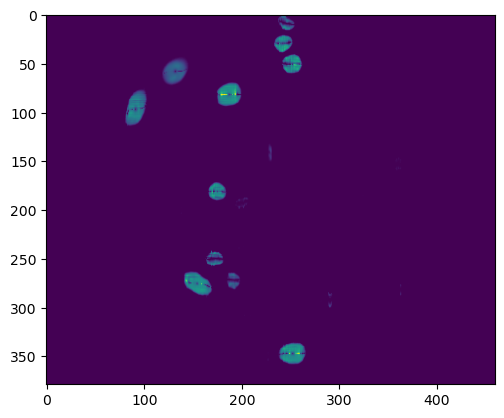

In [39]:
plt.imshow(flows[0][...,0][5])

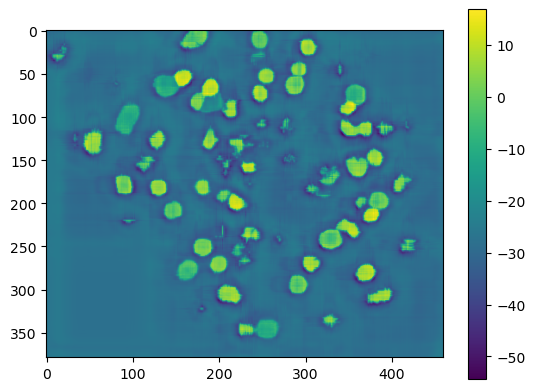

In [46]:
plt.imshow(flows[2][10])
plt.colorbar()

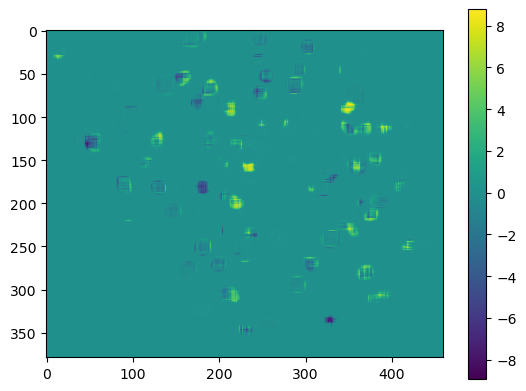

In [42]:
plt.imshow(flows[1][0,10])
plt.colorbar()